# Measuring speed from CPU times per event
### Authors: Andrea Sciabà, Andrea Valassi

The goal is to measure the CPU power of sites from the CPU time per event of ATLAS production jobs.

In [37]:
import sys
import math
import csv
from collections import defaultdict, OrderedDict, Counter
import pprint as pp
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline

First, let's read the data from the CSV file.

In [2]:
df = pd.read_csv('task_cms2.csv', names=['request', 'processingtype', 'site',
                                                               'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'evts', 'eff'])

Let's choose jobs of a given processing type by site or cpu.

In [135]:
event_type = 'dataprocessing'
mode = 'site'
wc_contrib = 0.001
output_file = ('results_' + mode + '_' + 'task_cms'
               + '_' + event_type + '_' + str(wc_contrib) + '.csv')

Let's find out which sites or CPU's contribute by more than 0.1% to the total wallclock time and restrict the analysis to them.

In [136]:
grouped = df[df.processingtype == event_type].groupby([mode], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
big_sites = a[a.wc > bigtotal_wc *wc_contrib][mode].tolist()

Let's store in a dict indexed by the task number and the site or CPU type the averages and standard deviations of the CPU time per event.

In [137]:
grouped = df.groupby(['processingtype', 'request', mode], as_index=False, sort=False)

data = defaultdict(OrderedDict)
for (p, j, s), g in grouped:
    if s not in big_sites: continue
    if p != event_type: continue
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[j][s] = (x, y)

Let's forget about tasks which run on only one site or CPU type.

In [138]:
# Remove from data tasks with only one site
for (k, v) in data.items():
    if len(v) == 1:
        del data[k]

Let's map sites or CPU types to integers and store the mapping for later use.

In [139]:
i = -1
sites = set()
smap = dict()
for (k, v) in data.items():
    for s in v.keys():
        if s not in sites:
            i += 1
            smap[s] = i
            sites.add(s)
        data[k][smap[s]]= data[k][s]
        del data[k][s]

nsites = len(smap)
print 'There are %s sites in the fit' % nsites

There are 32 sites in the fit


Let's also map tasks to integers.

In [140]:
# Map tasks to integers
tasks = set(data.keys())
tmap = dict()
i = 0
for x in tasks:
    tmap[x] = i
    i += 1

## Second analysis

This analysis uses a much better model and procedure to fit the speeds.

In the following, $\alpha$ indicates an index running over tasks and $i$ and index running over sites or CPU times.
The population average of the CPU time per event for task $\alpha$ at site or CPU $i$ is $\mu_{i\alpha}$ and the average we measure is $a_{i\alpha}$. Of course, not all sites or CPU types appear on all tasks, so sums over $i$ run only on sites or CPU types where the task runs.

It is assumed that the $a_{i\alpha}$ values we measure are Gaussian-distributed around $\mu_{i\alpha}$ with standard deviation $\sigma_{i\alpha}$.

It is also assumed that the speed factors $k_i$ do not depend on $\alpha$, and in particular that $\mu_{i\alpha}k_i=A_\alpha$, where $A_\alpha$ is a constant with respect to $i$.

It is assumed that also $\sigma_{i\alpha}=S_\alpha\mu_{i\alpha},\:\forall i, \alpha$.

To make the analysis easier, we choose to use $\sigma_{i\alpha}$ as errors on $a_{i\alpha}$, while it would be more correct to use $\sigma_{i\alpha}/\sqrt{N_{i\alpha}}$, where $N_{i\alpha}$ is the number of jobs run at site or CPU type $i$ for task $\alpha$ (_approx. #1_).

We also assume that $S_\alpha = S$, where $S$ is constant for all tasks (_approx. #2_).

The $\chi^2$ we want to minimise is the following:

$$\chi^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{\sigma_{i\alpha}}\right)^2=\sum_{i\alpha}\left(\frac{a_{i\alpha}-\mu_{i\alpha}}{S_\alpha\mu_{i\alpha}}\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}}{\mu_{i\alpha}}-1\right)^2=\sum_\alpha\frac{1}{S_\alpha^2}\sum_i\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)^2$$

finally, taking into account the approximations above:

$$\boxed{\chi^2=\frac{1}{S^2}\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2}$$

As $S$ is a constant, we can minimise a function $f=S^2\chi^2$ and the free parameters are $A_\alpha$ and $k_i$.

To recap, the function to minimise is

$$f=\sum_\alpha\frac{1}{A_\alpha^2}\sum_i\left(a_{i\alpha}k_i-A_\alpha\right)^2$$

its gradient is

$$\begin{align}\frac{\partial f}{\partial A_\alpha}&=-2\sum_i\frac{a_{i\alpha}k_i}{A_\alpha^2}\left(\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)\\\frac{\partial f}{\partial k_i}&=\sum_\alpha\frac{1}{A_\alpha^2}2a_{i\alpha}(a_{i\alpha}k_i-A_\alpha)\end{align}$$

and its Hessian is

$$\begin{align}\frac{\partial^2f}{\partial A_\alpha\partial A_\beta}&=\delta_{\alpha\beta}\times\frac{2}{A_\alpha^4}\sum_i(3a_{i\alpha}^2k_i^2-2a_{i\alpha}k_i A_\alpha)\\
\frac{\partial^2f}{\partial k_i\partial k_j}&=\delta_{ij}\times 2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}\\
\frac{\partial^2f}{\partial k_i\partial A_\alpha}&=-2\frac{a_{i\alpha}}{A_\alpha^2}\left(2\frac{a_{i\alpha}k_i}{A_\alpha}-1\right)
\end{align}$$

We use as initial values $k_i=1$ and $A_\alpha=(\sum_i a_{i\alpha})/n_\alpha$, where $n_\alpha$ is the number of sites or CPU types in task $\alpha$.

In [141]:
ntask = len(data)
nsite = len(smap)
a_ini = np.zeros(ntask)
for j, task in data.items():
    nt = tmap[j]
    a_ini[nt] = np.mean([b[0] for b in task.values()])
x_ini = np.hstack((a_ini, np.ones(nsite)))

In [142]:
print "Tasks: ", ntask
print "Sites/CPUs: ", nsite
print "Sum of initial values: ", np.sum(x_ini)

Tasks:  176
Sites/CPUs:  32
Sum of initial values:  2499.06330367


The function and its derivatives are implemented.

In [118]:
def func_val(x):
    a = x[:ntask]
    k = x[ntask:]
    total = 0.
    for j, task in data.items():   # looping on tasks
        nt = tmap[j]
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([b[0] for b in task.values()])
        f_term = 1. / a[nt]**2 * (v * kf - a[nt])**2
        delta = np.sum(f_term)
        total += delta
    return total

In [119]:
def grad_val(x):
    a = x[:ntask]
    k = x[ntask:]
    g = np.zeros(len(x))
    for j, task in data.items():
        g_a = 0.
        nt = tmap[j]
        for i in task.keys():
            (v, _) = task[i]
            g_a += -2 * v * k[i] / a[nt]**2 * (v * k[i] / a[nt] - 1)
            g_k = 2 / a[nt]**2 * v * (k[i] * v - a[nt])
            g[ntask + i] += g_k
        g[nt] = g_a
    return g

In [120]:
def hess_val(x):
    a = x[:ntask]
    k = x[ntask:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    for t, task in data.items():
        h = 0.
        nt = tmap[t]
        for i in task.keys():
            (v, _) = task[i]
            h += 2 / a[nt]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[nt])
            diag[ntask + i] += 2 * v**2 / a[nt]**2
            H[nt][ntask+i] = H[ntask+i][nt] = -2 * v / a[nt]**2 * ( 2 * v * k[i] / a[nt] - 1)
        diag[nt] = h
    H = H + np.diag(diag)
    return H

In [143]:
func_val(x_ini)

2708.0010013879532

In [144]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

0.0857509324231


The minimisation is performed.

In [145]:
result_val = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 534.482517
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 23
         Hessian evaluations: 8


It is worth noting that the problem is underdetermined: multiplying all $k_i$ and all $A_\alpha$ by the same number would not change the value of the function. Hence, the absolute scale of the fitted parameters has no meaning (as expected), and they should be rescaled to an appropriate reference. In principle, the fit should not converge, but it does. A more rigorous approach would be to fix one of the $k_i$ parameters to one and reduce by one the number of parameters fitted. This is left as a future improvement.

The fitted parameters are printed:

In [146]:
k_val = result_val.x[ntask:]

In [147]:
print k_val

[ 0.94910835  0.97993167  1.0233358   0.94534259  0.98164222  0.95172321
  1.03868272  1.00289872  1.02299137  0.97476872  0.89922791  0.97151535
  0.92467574  1.02713802  0.97241278  0.9841212   1.0083291   1.00076955
  1.00170091  0.95905387  0.90260545  1.00144424  1.01182789  1.0001956
  0.72587772  0.97785596  0.05489518  0.97859432  0.96108954  1.01001019
  1.00648872  0.6386813 ]


In [148]:
for s in sorted(smap.keys()):
    print '%s\t%.4f' % (s, k_val[smap[s]])

t1_de_kit	0.9517
t1_es_pic	1.0230
t1_fr_ccin2p3	0.9799
t1_it_cnaf	0.9816
t1_ru_jinr	1.0387
t1_uk_ral	0.9748
t1_us_fnal	0.9491
t2_be_iihe	0.9591
t2_ch_cern	0.8992
t2_ch_cern_hlt	0.6387
t2_ch_cscs	1.0118
t2_de_desy	0.9453
t2_de_rwth	0.9247
t2_es_ciemat	0.9611
t2_fr_ccin2p3	1.0083
t2_fr_grif_irfu	1.0065
t2_fr_grif_llr	0.9841
t2_fr_iphc	1.0014
t2_it_bari	0.9724
t2_it_legnaro	1.0008
t2_it_pisa	0.9715
t2_pt_ncg_lisbon	0.9026
t2_uk_london_brunel	1.0100
t2_uk_london_ic	1.0017
t2_uk_sgrid_ralpp	1.0271
t2_us_caltech	0.9779
t2_us_florida	0.7259
t2_us_mit	0.0549
t2_us_nebraska	1.0029
t2_us_purdue	1.0233
t2_us_ucsd	0.9786
t2_us_wisconsin	1.0002


As a check, the values fitted with this method are compared with the values fitted with the rolling ratios method.

### Error estimation

In order to estimate the error on the fitted parameters, we can use the standard method of finding the variations on the parameters that increase the value of $\chi^2$ by one with respect to its minimum. To do this, we must calculate the value of $S$.

From what was said above:

$$S=\frac{\sigma_{i\alpha}k_i}{A_\alpha}$$

and considering that $\sigma_{i\alpha}$ is the standard deviation of $a_{i\alpha}$, we can expect that the observed values $\frac{a_{i\alpha}k_i}{A_\alpha}$ will be distributed around one with a standard deviation of $S$.

Around the minimum, the following equation holds:

$$1\equiv\chi^2-\chi^2_{\text{min}}=\frac{\Delta f}{S^2}\simeq\frac{1}{S^2}\frac{1}{2}\frac{\partial^2f}{\partial k_i^2}\Delta k_i^2$$

and considering that

$$\frac{\partial^2f}{\partial k_i^2}=2\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}$$

one concludes that

$$\Delta k_i\simeq\frac{S}{\sqrt{\sum_\alpha\frac{a_{i\alpha}^2}{A_\alpha^2}}}$$

We can easily measure $S$ from the data as follows.

In [149]:
x = result_val.x
points = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v * x[ntask+i] / x[nt]
        points.append(p)

The value of S is: 0.454


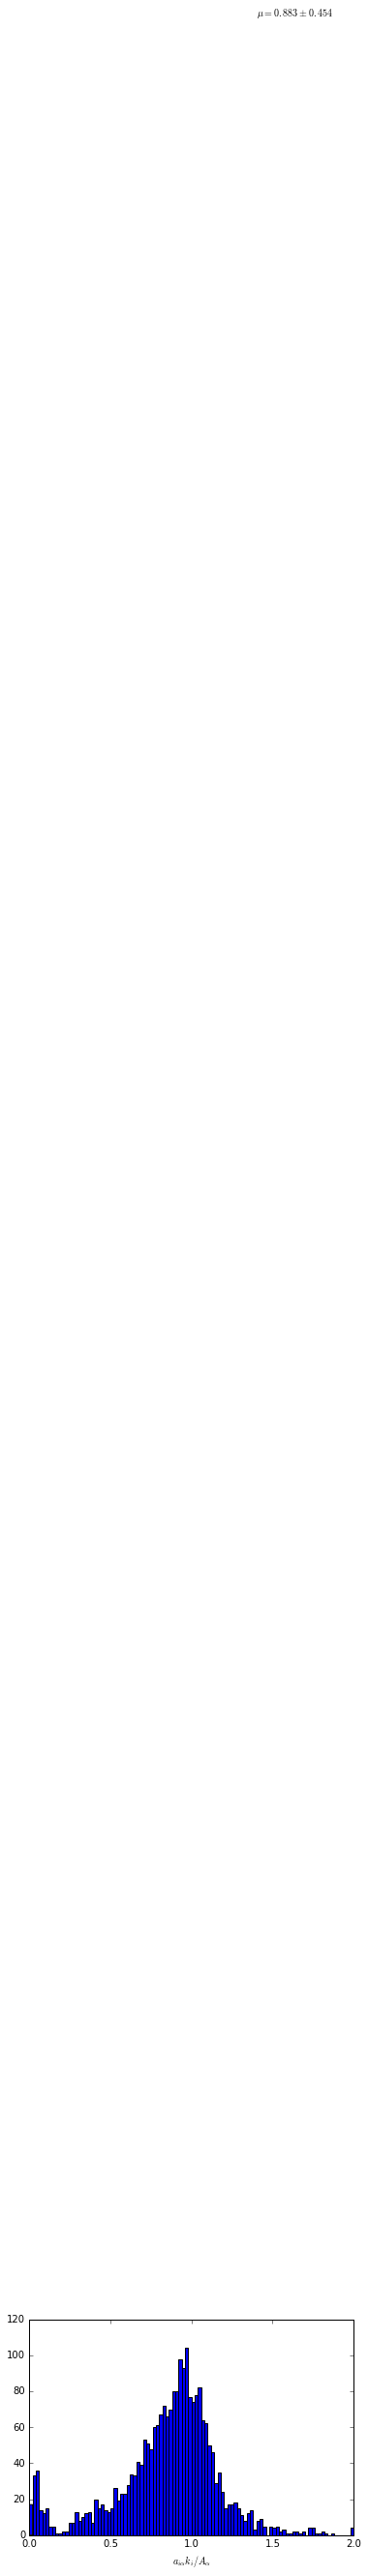

In [150]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points, bins=bins, range=xrange)
n = len(points)
mu = np.mean(points)
sigma = np.std(points)
plt.xlabel(r'$a_{i\alpha}k_i/A_\alpha$')
plt.text(1.4, 1400., r'$\mu=%.3f\pm%.3f$' % (mu, sigma))
S = sigma
print 'The value of S is: %.3f' % S

For fun, let's fit the distribution with one gaussian.

In [151]:
y, x = np.histogram(points, bins=bins, range=xrange)
y = np.divide(y, np.float(np.sum(y))*binsize)

0.903325529435 0.226695590461
The value of S is: 0.227


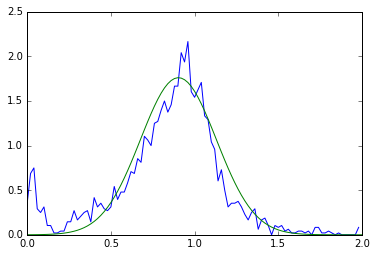

In [152]:
def f(x, m, s):
    return 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

plt.plot(x[:-1], y)
(m, s), _ = optimize.curve_fit(f, x[:-1], y)
print m, s
plt.plot(x, f(x, m, s))
S1 = s
print 'The value of S is: %.3f' % S1

And now, with two gaussians.

0.911550054733 0.164194854879 0.563806062996 0.632968686724
The value of S is: 0.366


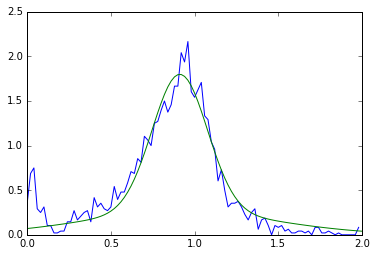

In [153]:
def f2(x, m, s1, s2, n):
    return n / (s1 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s1**2)) + \
        (1 - n) / (s2 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s2**2))
 
plt.plot(x[:-1], y)
(m, s1, s2, n), _ = optimize.curve_fit(f2, x[:-1], y, (1., 0.1, 1., 1.))
print m, s1, s2, n
plt.plot(x, f2(x, m, s1, s2, n))
S2 = np.sqrt(n * s1**2 + (1 - n) * s2**2)
print 'The value of S is: %.3f' % S2

The fit to two gaussians is remarkably good.

In [154]:
x = result_val.x
points2 = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v / a_ini[nt]
        points2.append(p)

The value of S is: 1.055


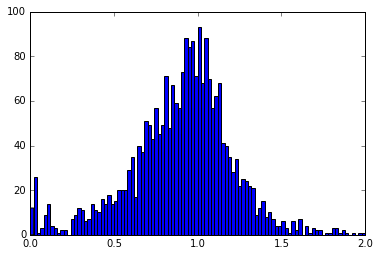

In [155]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points2, bins=bins, range=xrange)
n = len(points2)
mu = np.mean(points2)
sigma = np.std(points2)
print 'The value of S is: %.3f' % sigma

In [156]:
x = result_val.x
a = x[:ntask]
k = x[ntask:]
k_err = np.zeros_like(k)
c = 0
for t, task in data.items():
    nt = tmap[t]
    c += len(task)
    for i in task.keys():
        (v, _) = task[i]
        k_err[i] += v**2 / a[nt]**2
k_err = S / np.sqrt(k_err)

In [157]:
with open(output_file, 'wb') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    for s in sorted(smap.keys()):
        w.writerow([s, k[smap[s]], k_err[smap[s]]])

### Goodness of fit

To test the goodness of our fit, we can calculate the reduced $\chi^2$ ad the minimum, which is $\chi^2/(N-m)$, where $N$ is the number of independent measurements and $m$ the number of fitted parameters.

In [33]:
deg = c - len(x_ini)
chi2r = func_val(result_val.x) / S**2 / deg
print 'Degrees of freedom: %d' % deg
print 'The value of the reduced chi2 is: %.3f' % chi2r
print 'Standard deviation of reduced chi2: %.3f' % (1. / np.sqrt(2. * deg))

Degrees of freedom: 35154
The value of the reduced chi2 is: 1.278
Standard deviation of reduced chi2: 0.004
